In [2]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

In [63]:
df = pd.read_csv('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/PS_20174392719_1491204439457_log.csv')
# given 1 step is 1 hour, we want to have 7 days, step = 168
df = df[df['step'] <= 168]
df = df.drop(columns=['isFlaggedFraud'])
#df = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])]
# make sure nameOrig is unique

In [ ]:
df.to_csv('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/PS_20174392719_log.csv', index=False)

In [22]:
#columns_to_drop = ['isFraud', 'nameOrig', 'oldbalanceOrg', 'nameDest', 'oldbalanceDest']
#X = df_balanced.drop(columns_to_drop, axis=1)
#y = df_balanced['isFraud']

In [24]:
# Check uniqueness for 'nameOrig'
is_nameOrig_unique = df['nameOrig'].nunique() == len(df)

# Check uniqueness for 'nameDest'
is_nameDest_unique = df['nameDest'].nunique() == len(df)

print(f"Are all values in 'nameOrig' unique? {is_nameOrig_unique}")
print(f"Are all values in 'nameDest' unique? {is_nameDest_unique}")

Are all values in 'nameOrig' unique? False
Are all values in 'nameDest' unique? False


In [25]:
with pd.option_context('display.max_rows', None):
    print((df.dtypes))

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object


In [26]:
# Group by 'step' and 'nameOrig', then count the number of transactions in each group
grouped = df.groupby(['step', 'nameOrig']).size()

# Filter groups where the size is more than 1, indicating multiple transactions by the same customer in the same hour
multiple_transactions = grouped[grouped > 1]

# Count the number of unique groups where a customer has made multiple transactions in the same hour
unique_groups_count = len(multiple_transactions)
unique_groups_count

2

In [27]:
# EDA

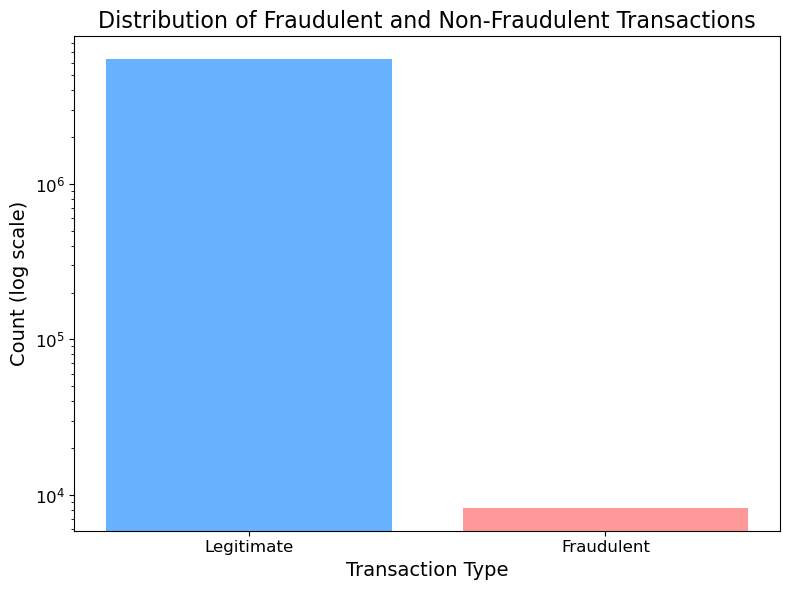

In [67]:
# Extracting the counts
counts = df['isFraud'].value_counts()
# Labels based on unique values in 'isFraud'
labels = ['Legitimate' if not i else 'Fraudulent' for i in counts.index]
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#66b2ff', '#ff9999']  # Light blue for 'Not Fraud' and light red for 'Fraud'
ax.bar(labels, counts, color=colors)

# Set the scale of y-axis to logarithmic so the fraud cases are visible
ax.set_yscale('log')

# Add title and labels
ax.set_title('Distribution of Fraudulent and Non-Fraudulent Transactions', fontsize = 16)
ax.set_ylabel('Count (log scale)', fontsize = 14)
ax.set_xlabel('Transaction Type', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/Figure1.png', dpi=300, bbox_inches='tight')
plt.show()


#If the coefficient is high: it is a good idea to remove all but one of the strongly correlated features. This will have no impact on your model's performance, but may speed-up its convergence time. In this case: I plan to use the difference?

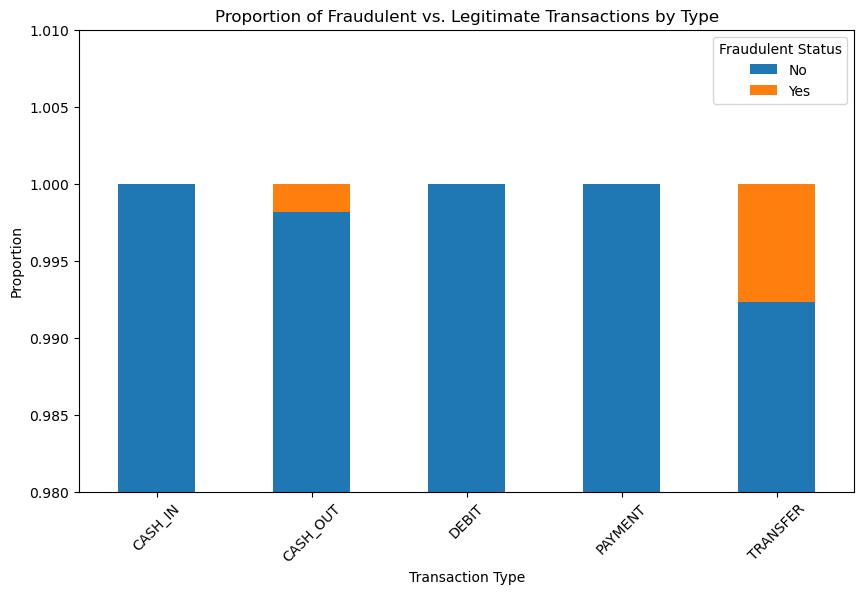

In [68]:
# Using previous code to get fraud_proportions
fraud_counts = df.groupby(['type', 'isFraud']).size().unstack()
fraud_proportions = fraud_counts.div(fraud_counts.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fraud_proportions.plot(kind='bar', stacked=True, ax=ax)
plt.title('Proportion of Fraudulent vs. Legitimate Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.ylim([0.98, 1.01])
plt.legend(title='Fraudulent Status', loc='upper right', labels=['No', 'Yes'])
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/Figure2.png', dpi=300, bbox_inches='tight')
plt.show()


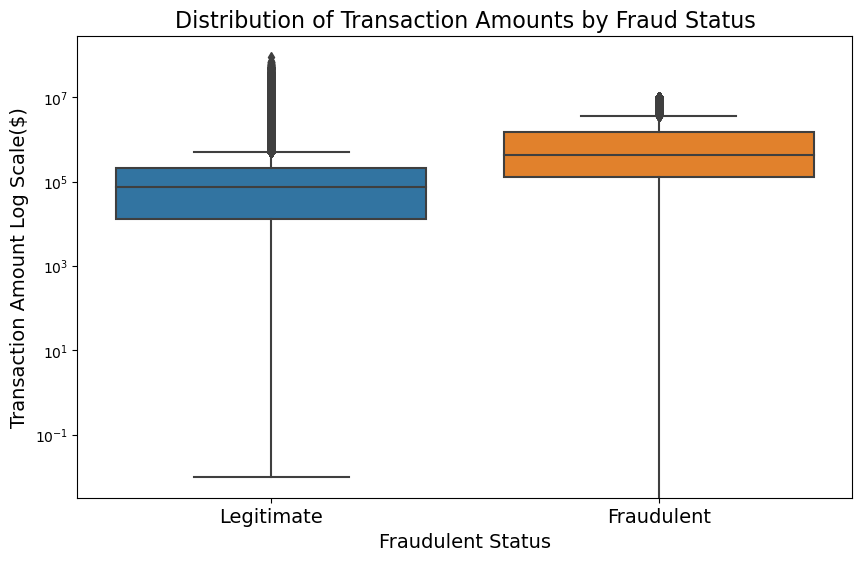

In [69]:
# amount and Fraud
# Drawing the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', data=df)

# Setting labels and title
plt.title('Distribution of Transaction Amounts by Fraud Status', fontsize = 16)
plt.xlabel('Fraudulent Status', fontsize = 14)
plt.ylabel('Transaction Amount Log Scale($)', fontsize = 14)
plt.yscale('log')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], fontsize = 14)  # Assuming isFraud has values 0 and 1
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/Figure3.png', dpi=300, bbox_inches='tight')
plt.show()


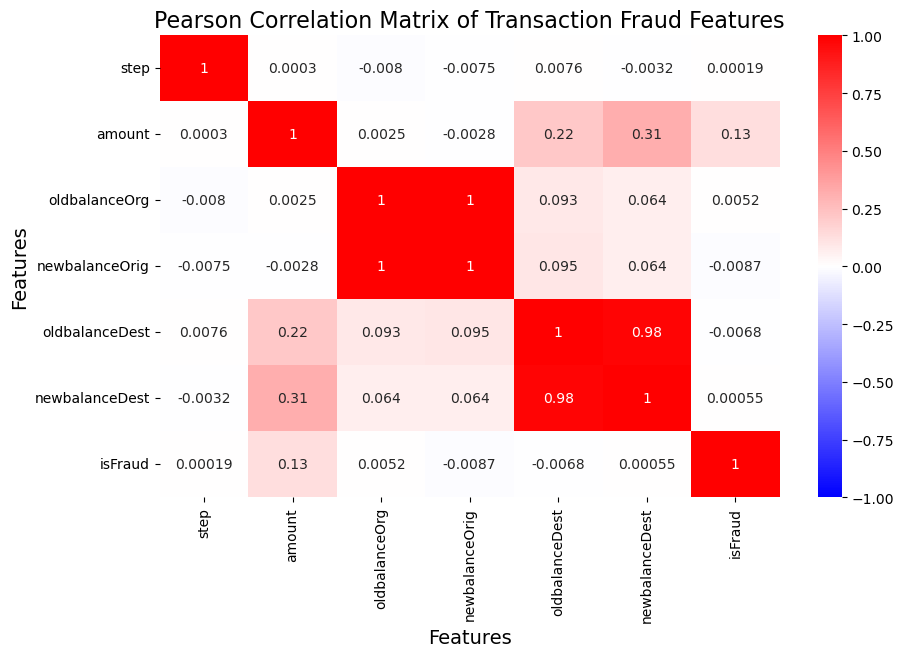

In [62]:
# Correlation matrix
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix of Transaction Fraud Features', fontsize = 16)
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Features', fontsize = 14)
plt.savefig('/Users/chujunchen/Desktop/DATA1030-Pony/Final Project/Figure4.png', dpi=300, bbox_inches='tight')
plt.show()


In [70]:
columns_to_drop = ['isFraud', 'nameOrig', 'oldbalanceOrg', 'nameDest', 'oldbalanceDest']
X = df.drop(columns_to_drop, axis=1)
y = df['isFraud']